In [66]:
import numpy as np
from astropy import units as u, constants as c
import json
from glob import glob
from astropy.table import Table,Column
import random as r
import scipy.optimize as opt
from astropy.coordinates import SkyCoord
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

Reading in file with ATNF Catalog listings for binary pulsars.
Includes binary periods (pbs), companion types (comptmp), $\dot{\omega}$s (omtmp), eccentricities (ecctmp), spin periods (p0s), and pulsar names (names).

In [67]:
pbs,comptmp,omtmp,ecctmp,p0s,names,p1tmp=np.loadtxt('binary_psrcatquery.txt',usecols=[1,2,3,4,5,6,7],dtype=str,unpack=True)


Formatting the arrays, as several of the catalog values are missing/include extra information.

In [68]:
pbs=np.array(pbs.astype(float))
ctypes=[]
comps=[]
for cmp in comptmp:
    cmp_strip=cmp.split('[')[0].split('(')[0]
    if cmp_strip=='*':
        cmp_strip='Unknown'
    if cmp_strip not in ctypes:
        ctypes.append(cmp_strip)
    if cmp_strip!='*':
        comps.append(cmp_strip)
    else:
        comps.append('Unknown')
omdots,eccs=[],[]
for om,ecc in zip(omtmp,ecctmp):
    if om!='*':
        omdots.append(float(om))
    else:
        omdots.append('*')
    if ecc!='*':
        eccs.append(float(ecc))
    else:
        eccs.append('*')
ecc=[]
for v in eccs:
    if v=='*':
        ecc.append(0)
    else:
        ecc.append(v)
#omdots=np.array(omdots)
#eccs=np.array(eccs)
ctypes=np.array(ctypes)
comps=np.array(comps)
p0s=np.array(p0s.astype(float))
p1s=[]
for v in p1tmp:
    try:
        p1s.append(float(v))
    except:
        p1s.append('*')


First, the relationship between spin period and and orbital period is plotted. These points are colored by their eccentricities and shaped by their companion types. Also included on the plot is a point for the pulsar in question, J2038+35. Determining the eccentricity of the source seems as though it may uncover whether the companion is a main sequence star or a white dwarf, as points in the neighborhood of 2038 are either eccentric MS companions or circular WD companions.

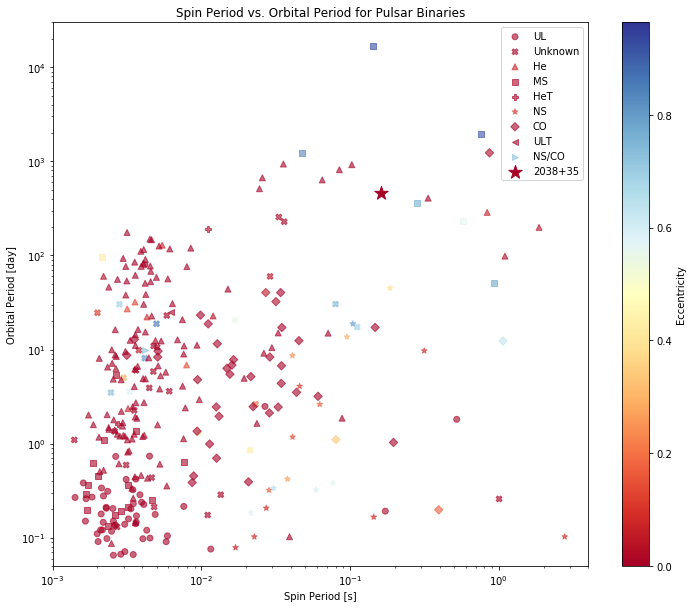

In [84]:
cmr=plt.cm.get_cmap('RdYlBu')
markers=['o','X','^','s','P','*','D','<','>']
clrs=[]
for e in eccs:
    if e!='*':
        clrs.append(cmr(float(e)))
    else:
        clrs.append(cmr(2))
sc_p0pb=plt.scatter(p0s,pbs,c=ecc,cmap=cmr)
cb=plt.colorbar(sc_p0pb)
plt.close()        
plt.figure(figsize=(12,10))
plt.xlabel('Spin Period [s]')
plt.ylabel('Orbital Period [day]')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(sc_p0pb,label='Eccentricity')
plt.title('Spin Period vs. Orbital Period for Pulsar Binaries')
for m,ct in zip(markers,ctypes):
    cnd = np.array(comps==ct)
    plt.scatter(np.array(p0s)[cnd],np.array(pbs)[cnd],c=np.array(clrs)[cnd],cmap=cmr,marker=m,label=ct,alpha=0.6)
pb_2038=462.51578189875295 
p0_2038=1/6.243567392
plt.scatter(p0_2038,pb_2038,c=mpl.colors.to_hex(cmr(0)),marker='*',s=200,label='2038+35')
plt.legend()
plt.xlim([1e-3,4])
plt.ylim([5e-2,3e4])
plt.show()
#plt.savefig('p0vspb.pdf')

Next, we move onto testing the suitability of the 2038 system for tests of GR, namely the SEP. These calculations follow from Stairs et. al (2003), where the important criteria for making a binary system suitable for SEP tests include the following: 

1. P$_{\rm b}$$^2$/$e$ $>$ 10$^7$ yr$^2$. This sets the "forced" eccentricity term (the component of the eccentricity vector due to the gravitational potential of the Galaxy) to be significant enough to measure.

2. $\dot{\omega}_{\rm orbit}$ $>$ $\dot{\omega}_{\rm Galaxy}$. This implies that the projection of the Galactic gravitational acceleration is ~constant.

3. $\tau_c$ $>>$ 2$\pi$/$\dot{\omega}_{\rm orbit}$. In this limit, the time-dependent eccentricity vector is randomly oriented. For pulsars, $\tau_c$ = P/2$\dot{\rm P}$.



In [79]:
def omdot(pb,e,mc,mp=1.4):
    t0=c.G*c.M_sun/c.c**3
    if str(type(e)) in [list,np.ndarray]:
        omd_arr=[]
        for ecc in e:
            omd_arr.append(omdot(pb,e,mc,mp))
        return np.array(omd_arr)
    return (u.rad*3*t0**(2./3)*(pb/(2*np.pi))**(-5./3)*(mp+mc)**(2./3)/(1-e**2)).decompose().to('rad/s')

def dot(l1,l2):
    return np.array([bool(v1) and bool(v2) for v1,v2 in zip(l1,l2)])

In [92]:
od_2317=omdot(pb=2.4593*u.day,e=5.202e-07,mc=0.1721)
e_2317=5.202e-07
pb2_e_2317=(2.4593**2)/e_2317

od_1012=omdot(pb=0.6047*u.day,e=1.301e-6,mc=0.1071)
e_1012=1.301e-6
pb2_e_1012=(0.6047**2)/e_1012

#e_arr=np.logspace(-5,0,30)
e_arr=np.linspace(1e-5,1,20)
od_2038=omdot(pb=462.51578189875295*u.day,e=e_arr,mc=0.4)
pb2_e_2038=(462.51578189875295**2)/e_arr

/Users/aemcewen/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Here, we consider the first two criteria. We plot the expected $\dot{\omega}_{\rm orbit}$ for a range of eccentricities against the corresponding P$_{\rm b}^2$/$e$. The value of P$_{\rm b}$, measured from timing, is ~462.5 days. While the eccentricity is still unknown, we expect it to be fairly small, putting the system above the minimum binary orbit criteria (#1 in the above list). The second criterion is represented via the Galactic rotation rate at the position of 2038+35. This uses the DM distance (from NE2001, https://www.nrl.navy.mil/rsd/RORF/ne2001/#los). As mentioned in Stairs et. al, binary orbital periods under 1000 days generally satisfy this constraint, which is reflected in our estimated rate plotted with a green dashed line below. Also included on this plot are points for two pulsars mentioned in the SEP section of Stairs et. al, J2317+1439 (star) and J1012+5307 (filled "+"). 

Text(0.5, 1.0, 'Equivalence Principle Criteria for J2038+35')

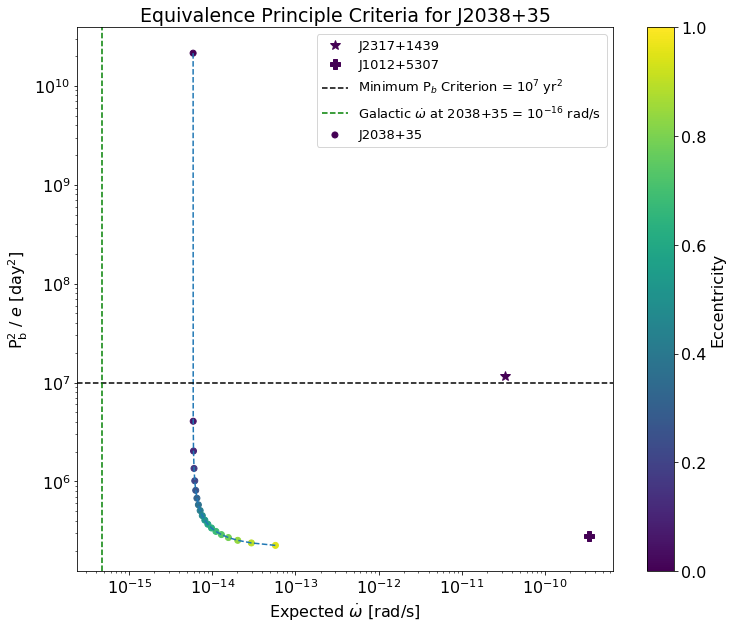

In [93]:
cmv=plt.cm.get_cmap('viridis')
plt.figure(figsize=(12,10))
fs=16
plt.xscale('log')
plt.yscale('log')
plt.plot(od_2317,pb2_e_2317,marker='*',label='J2317+1439',linewidth=0,markersize=10,color=mpl.colors.to_hex(cmv(e_2317)))
plt.plot(od_1012,pb2_e_1012,marker='P',label='J1012+5307',linewidth=0,markersize=10,color=mpl.colors.to_hex(cmv(e_1012)))

sc_odpb=plt.scatter(od_2038,pb2_e_2038,c=[mpl.colors.to_hex(cm(v)) for v in e_arr],label='J2038+35')
plt.plot(od_2038,pb2_e_2038,markersize=0,ls='--')

cbar=plt.colorbar(sc_odpb)
cbar.ax.tick_params(labelsize=fs)
plt.tick_params(labelsize=fs)
cbar.set_label(label='Eccentricity',fontsize=fs)
plt.xlabel(r'Expected $\dot{\omega}$ [rad/s]',fontsize=fs)
plt.ylabel(r'$\rm P_{\rm b}^2$ / $e$ [day$^2$]',fontsize=fs)
plt.axhline(y=1e7,ls='--',color='k',label=r'Minimum P$_b$ Criterion = 10$^7$ yr$^2$')
plt.axvline(x=4.7e-16,ls='--',color='green',label='Galactic $\dot{\omega}$ at 2038+35 = 10$^{-16}$ rad/s')
plt.legend(fontsize=fs-3)
plt.title('Equivalence Principle Criteria for J2038+35',fontsize=fs+3)

The final criterion is now considered. A limitation we are currently facing with timing is an inability to break degeneracies between spindown ($\dot{P}$) and position. So, we do not have a reliable measurement of $\dot{\rm P}$ - but, using criterion #3, we can set upper limits on allowed spindown such that the characteristic age $\tau_{\rm c}$ is significantly larger than the timescale of periastron advance. Note that the required spindown for low eccentricity ($\lesssim$ 10$^{-16}$) places this system in the region of the P-$\dot{\rm P}$ diagram somewhat between typical young pulsars and the branch of recycled/binary pulsars, as shown in the diagram below. 

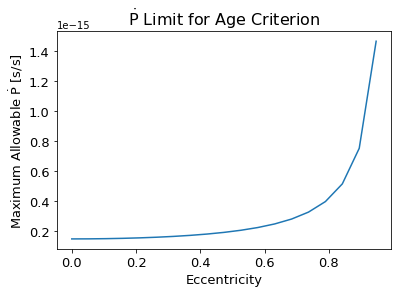

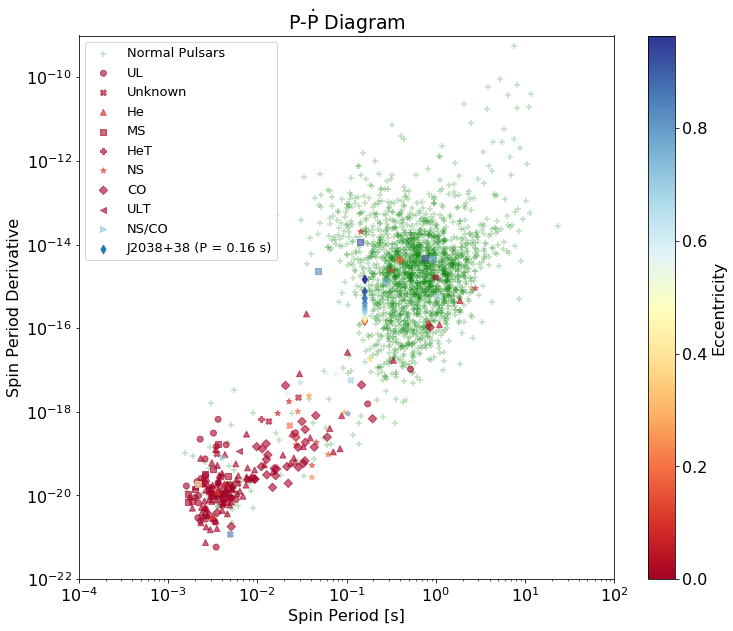

In [99]:
p0=1*u.s/6.243567392
p1_2038=p0*od_2038/(2*np.pi)
plt.plot(e_arr,p1_2038)
plt.xlabel('Eccentricity',fontsize=fs-3)
plt.ylabel(r'Maximum Allowable $\dot{\rm P}$ [s/s]',fontsize=fs-3)
plt.title(r'$\dot{\rm P}$ Limit for Age Criterion',fontsize=fs)
plt.tick_params(labelsize=fs-3)
plt.show()

nb_p0,nb_p1=np.loadtxt('ppdot_nonbinary.txt',unpack=True)
plt.figure(figsize=(12,10))
plt.xscale('log')
plt.yscale('log')
plt.title(r'P-$\dot{\rm P}$ Diagram',fontsize=fs+3)
plt.xlabel('Spin Period [s]',fontsize=fs)
plt.ylabel('Spin Period Derivative',fontsize=fs)
plt.scatter(nb_p0,nb_p1,marker='+',alpha=0.25,color='green',label='Normal Pulsars')
#plt.scatter(np.array(p0s)[np.array(p1s)!='*'].astype(float),np.array(p1s)[np.array(p1s)!='*'].astype(float),marker='x',label='Non-Binary Pulsars')
for m,ct in zip(markers,ctypes):
    cnd = dot(np.array(comps==ct),np.array(p1s)!='*')
    plt.scatter(np.array(p0s)[cnd],np.array(p1s)[cnd].astype(float),c=np.array(clrs)[cnd],cmap=cmr,marker=m,label=ct,alpha=0.6)
plt.scatter(np.ones(len(p1_2038))*p0,p1_2038,c=e_arr,cmap=cmr,marker='d',label=r'J2038+38 (P = %2.2f s)'%p0.value)
plt.xlim([1e-4,1e2])
plt.ylim([1e-22,1e-9])
plt.legend(fontsize=fs-3)
cbar=plt.colorbar(sc_p0pb)
cbar.ax.tick_params(labelsize=fs)
plt.tick_params(labelsize=fs)
cbar.set_label(label='Eccentricity',fontsize=fs)
plt.show()